#### Finding an optimal template for finetuning

In [23]:
import numpy as np
import json
from PIL import Image
from tqdm import tqdm

In [24]:
def get_data(file_path, i):
    data = json.load(open(file_path))
    annotations = data["annotations"]
    ann1 = annotations[i]
    ann2 = annotations[i+1]
    return ann1, ann2

In [46]:
search_dirs = ["../../news_clippings/news_clippings/data/merged_balanced/train.json", 
 "../../news_clippings/news_clippings/data/person_sbert_text_text/train.json",
 "../../news_clippings/news_clippings/data/scene_resnet_place/train.json",
 "../../news_clippings/news_clippings/data/semantics_clip_text_image/train.json",
 "../../news_clippings/news_clippings/data/semantics_clip_text_text/train.json"]

In [47]:
def find_true(search_dirs, id_to_find):
    for search_dir in search_dirs:
        temp_data = json.load(open(search_dir))
        annotations = temp_data["annotations"]
        #search for true
        for ann in annotations:
            if id_to_find == ann['id'] and ann['falsified'] == False:
                return search_dir, ann

    return ";-;", ":("

In [48]:
def add_result(file_path, annotation):
    try:
        # Read the existing file
        with open(file_path, 'r') as file:
            data = json.load(file)
    except (FileNotFoundError, json.decoder.JSONDecodeError):
        # If the file doesn't exist or is empty, initialize an empty list
        data = []

    # Append the new result to the list
    data.append(annotation)

    # Write the updated list to the JSON file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

In [49]:
def get_data_elements(ann):
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}


    caption = visual_news_data_mapping[ann["id"]]["caption"]
    image_path = visual_news_data_mapping[ann["image_id"]]["image_path"]
    image_path = "../../datasets/visualnews/origin/"+image_path[2:]
    image = Image.open(image_path)
    return image, caption

In [54]:
ann1, ann2 = get_data("../../news_clippings/news_clippings/data/merged_balanced/train.json", 0)
search_dir, ann2_true = find_true(search_dirs, ann2['image_id'])

In [56]:
img1, cap1 = get_data_elements(ann1)
img2, cap2 = get_data_elements(ann2_true)

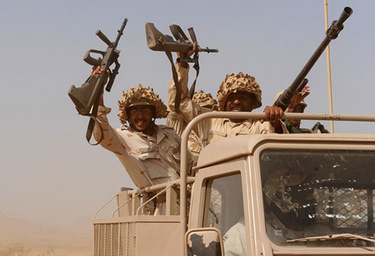

Saudi troops cheer as they ride at the back of an army truck in the southwestern province of Jizan near the border with Yemen
False


In [57]:
display(img1)
print(cap1)
print(ann1['falsified'])

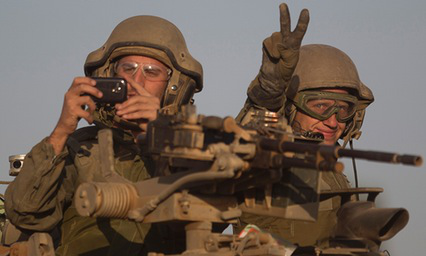

Israeli soldiers ride on a tank to a position near the Israel Gaza border
False


In [59]:
display(img2)
print(cap2)
print(ann2_true['falsified'])

In [69]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from PIL import Image

import requests
from PIL import Image
from io import BytesIO
from transformers import TextStreamer

from utils.data import get_data

In [61]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

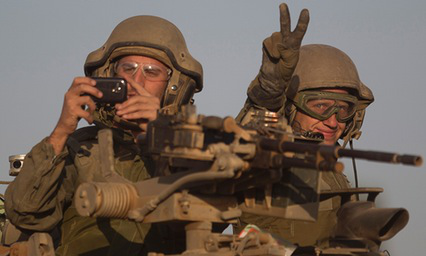

Israeli soldiers ride on a tank to a position near the Israel Gaza border
False


In [70]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = conv_templates[conv_mode].copy()
if "mpt" in model_name.lower():
    roles = ('user', 'assistant')
else:
    roles = conv.roles

image, caption, img_path, annotation = img2, cap2, "", ann2_true
image_size = image.size
#show data
display(image)
print(caption)
print(annotation['falsified'])

# Similar operation in model_worker.py
image_tensor = process_images([image], image_processor, model.config)
if type(image_tensor) is list:
    image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(model.device, dtype=torch.float16)

In [ ]:
def task_prompt(...):
    #define prompt to generate template based output similar to sniffer

In [ ]:
#define the task prompt to generate template based response - for finetuning
inp = task_prompt(roles[0], ...)

print(f"{roles[1]}: ", end="")

if image is not None:
    # first message
    if model.config.mm_use_im_start_end:
        inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    else:
        inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
    image = None

conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=image_tensor,
        image_sizes=[image_size],
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        max_new_tokens=max_new_tokens,
        streamer=streamer,
        use_cache=True)

outputs = tokenizer.decode(output_ids[0]).strip()
conv.messages[-1][-1] = outputs

print("\n", {"prompt": prompt, "outputs": outputs}, "\n")